<a href="https://colab.research.google.com/github/CASAttackZW2025/CAS502Project/blob/main/CAS502testv03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy


In [ ]:
import simpy
import random
import matplotlib.pyplot as plt

In [ ]:
class Job:
    def __init__(self, id, arrival_time, processing_rate, crane_prob, test_kit_prob):
        self.id = id
        self.arrival_time = arrival_time
        self.processing_time = random.expovariate(processing_rate)
        self.remaining_time = self.processing_time
        self.needs_crane = random.random() < crane_prob
        self.needs_test_kit = random.random() < test_kit_prob
        self.start_time = None
        self.finish_time = None

    def __str__(self):
        return (f"Job {self.id} (arrival: {self.arrival_time:.2f}, proc_time: {self.processing_time:.2f}, "
                f"crane: {self.needs_crane}, test kit: {self.needs_test_kit})")


class ExtraResource:
    def __init__(self, env, capacity, name):
        self.env = env
        self.resource = simpy.Resource(env, capacity=capacity)
        self.name = name


class Worker:
    def __init__(self, id, env, job_queue, crane, test_kit, shift_length, break_length, production_system):
        self.id = id
        self.env = env
        self.job_queue = job_queue
        self.crane = crane
        self.test_kit = test_kit
        self.shift_length = shift_length
        self.break_length = break_length
        self.cycle_length = shift_length + break_length
        self.production_system = production_system
        self.process = env.process(self.run())

    def run(self):
        while True:
            job = yield self.job_queue.get()
            if job is None:
                print(f"[{self.env.now:6.2f}] Worker {self.id} shutting down.")
                break
            print(f"[{self.env.now:6.2f}] Worker {self.id} picked up {job}.")

            if job.start_time is None:
                job.start_time = self.env.now

            crane_req = None
            test_req = None

            if job.needs_crane:
                crane_req = self.crane.resource.request()
                yield crane_req
                print(f"[{self.env.now:6.2f}] Worker {self.id} acquired {self.crane.name} for Job {job.id}.")

            if job.needs_test_kit:
                test_req = self.test_kit.resource.request()
                yield test_req
                print(f"[{self.env.now:6.2f}] Worker {self.id} acquired {self.test_kit.name} for Job {job.id}.")

            while job.remaining_time > 0:
                cycle_time = self.env.now % self.cycle_length
                if cycle_time >= self.shift_length:
                    wait_time = self.cycle_length - cycle_time
                    # print(f"[{self.env.now:6.2f}] Worker {self.id} is on break for {wait_time:.2f} time units.")
                    yield self.env.timeout(wait_time)
                    continue

                work_time_left = self.shift_length - cycle_time
                dt = min(job.remaining_time, work_time_left)
                yield self.env.timeout(dt)
                job.remaining_time -= dt

            job.finish_time = self.env.now
            print(f"[{self.env.now:6.2f}] Worker {self.id} finished Job {job.id}.")

            if job.needs_crane and crane_req is not None:
                self.crane.resource.release(crane_req)
            if job.needs_test_kit and test_req is not None:
                self.test_kit.resource.release(test_req)

            self.production_system.record_completion(job)

class ProductionSystem:
    def __init__(self, num_jobs, arrival_rate, processing_rate, num_workers,
                 crane_capacity, test_kit_capacity, crane_prob, test_kit_prob,
                 shift_length, break_length):
        self.num_jobs = num_jobs
        self.arrival_rate = arrival_rate
        self.processing_rate = processing_rate
        self.num_workers = num_workers
        self.crane_prob = crane_prob
        self.test_kit_prob = test_kit_prob
        self.shift_length = shift_length
        self.break_length = break_length
        self.env = simpy.Environment()
        self.job_queue = simpy.Store(self.env)
        self.crane = ExtraResource(self.env, capacity=crane_capacity, name="Crane")
        self.test_kit = ExtraResource(self.env, capacity=test_kit_capacity, name="Test Kit")
        self.completed_jobs = []
        self.production_log = []
        self.workers = [Worker(i, self.env, self.job_queue, self.crane, self.test_kit,
                                 shift_length, break_length, self) for i in range(num_workers)]
        self.env.process(self.job_generator())

    def job_generator(self):
        for i in range(self.num_jobs):
            yield self.env.timeout(random.expovariate(self.arrival_rate))
            job = Job(i, self.env.now, self.processing_rate, self.crane_prob, self.test_kit_prob)
            print(f"[{self.env.now:6.2f}] {job} arrives.")
            yield self.job_queue.put(job)

        for _ in range(self.num_workers):
            yield self.job_queue.put(None)

    def record_completion(self, job):
        self.completed_jobs.append(job)
        self.production_log.append((self.env.now, len(self.completed_jobs)))

    def run(self):
        self.env.run()

    def plot_production(self):
        if not self.production_log:
            print("No production log to plot.")
            return
        times, counts = zip(*self.production_log)
        plt.figure(figsize=(8, 5))
        plt.step(times, counts, where='post', label='Completed Jobs')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Completed Jobs')
        plt.title('Production Output Over Time')
        plt.grid(True)
        plt.legend()
        plt.show()

In [ ]:
num_jobs = 50
arrival_rate = 1.0
processing_rate = 1.0
num_workers = 3
crane_capacity = 1
test_kit_capacity = 4
crane_prob = 0.5
test_kit_prob = 0.3
shift_length = 6.5
break_length = 1.5
production_system = ProductionSystem(num_jobs, arrival_rate, processing_rate, num_workers,
                                         crane_capacity, test_kit_capacity,
                                         crane_prob, test_kit_prob,
                                         shift_length, break_length)

In [ ]:
production_system.run()

[  2.36] Job 0 (arrival: 2.36, proc_time: 1.51, crane: True, test kit: True) arrives.
[  2.36] Worker 0 picked up Job 0 (arrival: 2.36, proc_time: 1.51, crane: True, test kit: True).
[  2.36] Worker 0 acquired Crane for Job 0.
[  2.36] Worker 0 acquired Test Kit for Job 0.
[  3.88] Worker 0 finished Job 0.
[  3.98] Job 1 (arrival: 3.98, proc_time: 1.61, crane: True, test kit: False) arrives.
[  3.98] Worker 1 picked up Job 1 (arrival: 3.98, proc_time: 1.61, crane: True, test kit: False).
[  3.98] Worker 1 acquired Crane for Job 1.
[  5.09] Job 2 (arrival: 5.09, proc_time: 0.93, crane: True, test kit: False) arrives.
[  5.09] Worker 2 picked up Job 2 (arrival: 5.09, proc_time: 0.93, crane: True, test kit: False).
[  5.59] Worker 1 finished Job 1.
[  5.59] Worker 2 acquired Crane for Job 2.
[  5.74] Job 3 (arrival: 5.74, proc_time: 0.23, crane: True, test kit: False) arrives.
[  5.74] Worker 0 picked up Job 3 (arrival: 5.74, proc_time: 0.23, crane: True, test kit: False).
[  5.88] Job 4 

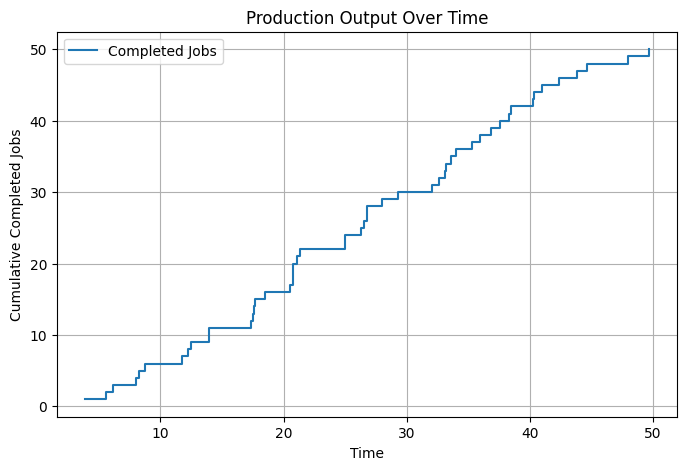

In [ ]:
production_system.plot_production()